In [26]:
import numpy as np
import tensorflow as tf
import os
import sys
import shutil
import time
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score, ConfusionMatrixDisplay
from preprocess import get_data

In [27]:

X_test_arr = np.load('./X_test_arr.npy',allow_pickle=True)
y_test_onehot_arr = np.load('./y_test_onehot_arr.npy',allow_pickle=True)

# print(loaded_arr)


In [28]:
dataset = 'EEG_CSV'
in_samples = 1125
n_channels = 14
n_sub = 1
classes_labels = ["tongue", "left_hand", "right_hand"]
n_classes = len(classes_labels)
data_path = './records/'
# Set dataset paramters
dataset_conf = { 'name': dataset, 'n_classes': n_classes, 'cl_labels': classes_labels,
                'n_sub': n_sub, 'n_channels': n_channels, 'in_samples': in_samples,
                'data_path': data_path, 'isStandard': True, 'LOSO': False}


In [29]:
# Get dataset
dataset = dataset_conf.get('name')
n_sub = dataset_conf.get('n_sub')
data_path = dataset_conf.get('data_path')
isStandard = dataset_conf.get('isStandard')
LOSO = dataset_conf.get('LOSO')
classes_labels = dataset_conf.get('cl_labels')
# #def arrays of datasets
# X_train_arr , y_train_arr , y_train_onehot_arr , X_test_arr , y_test_arr , y_test_onehot_arr = ( np.zeros(n_sub , dtype=object) for _ in range(6) )
# # print(n_sub)
# for sub in range(n_sub):
#     X_train_arr[sub], y_train_arr[sub], y_train_onehot_arr[sub], X_test_arr[sub] ,y_test_arr[sub] ,y_test_onehot_arr[sub] = get_data(
#                 data_path, sub, dataset, LOSO = LOSO, isStandard = isStandard,classes_labels = classes_labels)
    

In [30]:
# Load the TFLite model and allocate tensors.
model_path = './model_lite_05_13_09_14/model_05_13_09_14.tflite'
interpreter = tf.lite.Interpreter(model_path=model_path)
interpreter.allocate_tensors()


In [31]:
# Get input and output tensors.
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()


In [32]:
input_shape = input_details[0]['shape']
output_shape = output_details[0]['shape']
print(input_shape, output_shape)

[   1    1   14 1125] [1 3]


In [33]:
astype(np.float32)sub = 0
input_data = X_test_arr[sub].[:,None,:]
print(input_data.shape)

(62, 1, 1, 14, 1125)


In [34]:
y_test_onehot_arr[0].shape

(62, 3)

In [35]:
#test model
y_pred_arr = np.zeros(y_test_onehot_arr[0].shape)
for i in range(input_data.shape[0]):
    interpreter.set_tensor(input_details[0]['index'], input_data[i])
    interpreter.invoke()
    y_pred = interpreter.get_tensor(output_details[0]['index'])
    y_pred_arr[i] = y_pred[0]
    print(y_pred)

[[0.07241691 0.8381231  0.08946009]]
[[0.15838394 0.32491314 0.5167029 ]]
[[0.09723345 0.09894751 0.80381906]]
[[0.30633092 0.44218022 0.2514889 ]]
[[0.16751307 0.45114654 0.38134032]]
[[0.38153785 0.18319471 0.43526748]]
[[0.0649721  0.8503544  0.08467355]]
[[0.5290256  0.22776806 0.24320628]]
[[0.35331032 0.17054433 0.47614536]]
[[0.1007344  0.47144747 0.42781818]]
[[0.14612702 0.15992606 0.6939469 ]]
[[0.14152685 0.14070177 0.71777135]]
[[0.06954059 0.57127106 0.35918838]]
[[0.09268197 0.04946252 0.8578555 ]]
[[0.48121798 0.20434189 0.31444016]]
[[0.37497085 0.17717312 0.447856  ]]
[[0.18816195 0.56115454 0.25068352]]
[[0.04272601 0.03613991 0.9211341 ]]
[[0.13257703 0.24439865 0.62302434]]
[[0.1733228  0.59374034 0.23293681]]
[[0.03265783 0.921063   0.04627921]]
[[0.32714438 0.34777212 0.3250835 ]]
[[0.11451039 0.6682444  0.21724519]]
[[0.06096673 0.82298815 0.11604512]]
[[0.40129036 0.46819806 0.13051166]]
[[0.04457037 0.86635053 0.08907909]]
[[0.17586114 0.6946515  0.12948737]]
[

In [36]:
#plot functions
def draw_learning_curves(history, sub):
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy - subject: ' + str(sub))
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'val'], loc='upper left')
    plt.show()
    plt.figure(2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss - subject: ' + str(sub))
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'val'], loc='upper left')
    plt.show()
    plt.close()

def draw_confusion_matrix(cf_matrix, sub, results_path, classes_labels):
    # Generate confusion matrix plot
    display_labels = classes_labels
    disp = ConfusionMatrixDisplay(confusion_matrix=cf_matrix,
                                display_labels=display_labels)
    disp.plot()
    disp.ax_.set_xticklabels(display_labels, rotation=12)
    plt.title('Confusion Matrix of Subject: ' + sub )
    plt.savefig(results_path + '/subject_' + sub + '.png')
    plt.show()

def draw_performance_barChart(num_sub, metric, label):
    fig, ax = plt.subplots()
    x = list(range(1, num_sub+1))
    ax.bar(x, metric, 0.5, label=label)
    ax.set_ylabel(label)
    ax.set_xlabel("Subject")
    ax.set_xticks(x)
    ax.set_title('Model '+ label + ' per subject')
    ax.set_ylim([0,1])


In [37]:
#%% Evaluation
def test(y_test_onehot_arr, y_pred_arr, dataset_conf, results_path, allRuns = True):
    # Open the  "Log" file to write the evaluation results
    log_write = open(results_path + "/log.txt", "a")

    # Get dataset paramters
    # dataset = dataset_conf.get('name')
    n_classes = dataset_conf.get('n_classes')
    # n_sub = dataset_conf.get('n_sub')
    # data_path = dataset_conf.get('data_path')
    # isStandard = dataset_conf.get('isStandard')
    # LOSO = dataset_conf.get('LOSO')
    classes_labels = dataset_conf.get('cl_labels')
    n_sub = len(y_test_onehot_arr)
    # Test the performance based on several runs (seeds)
    # runs = os.listdir(results_path+"/saved models")
    # Initialize variables
    acc = np.zeros((n_sub, 1))
    kappa = np.zeros((n_sub, 1))
    cf_matrix = np.zeros([n_sub, 1, n_classes, n_classes])

    # Iteration over subjects
    # for sub in range(n_sub-1, n_sub): # (num_sub): for all subjects, (i-1,i): for the ith subject.
    inference_time = 0 #  inference_time: classification time for one trial
    for sub in range(n_sub): # (num_sub): for all subjects, (i-1,i): for the ith subject.
        # Load data
        X_test, y_test_onehot = X_test_arr[sub], y_test_onehot_arr[sub]
        # _, _, _, X_test, _, y_test_onehot = get_data(data_path, sub, dataset, LOSO = LOSO, isStandard = isStandard)

        # Iteration over runs (seeds)
        for seed in range(1):
            # Load the model of the seed.
            # model.load_weights('{}/saved models/{}/subject-{}.h5'.format(results_path, runs[seed], sub+1))

            inference_time = time.time()
            # Predict MI task
            label_pred = y_pred_arr.argmax(axis=-1)
            inference_time = (time.time() - inference_time)/X_test.shape[0]
            # Calculate accuracy and K-score
            labels = y_test_onehot.argmax(axis=-1)
            acc[sub, seed]  = accuracy_score(labels, label_pred)
            # kappa[sub, seed] = cohen_kappa_score(labels, y_pred)
            # Calculate and draw confusion matrix
            cf_matrix[sub, seed, :, :] = confusion_matrix(labels, label_pred, normalize='true')
            # draw_confusion_matrix(cf_matrix[sub, seed, :, :], str(sub+1), results_path, classes_labels)

    # Print & write the average performance measures for all subjects
    head1 = head2 = '                  '
    for sub in range(n_sub):
        head1 = head1 + 'sub_{}   '.format(sub+1)
        head2 = head2 + '-----   '
    head1 = head1 + '  average'
    head2 = head2 + '  -------'
    info = '\n' + head1 +'\n'+ head2
    info = '\n---------------------------------\nTest performance (acc & k-score):\n'
    info = info + '---------------------------------\n' + head1 +'\n'+ head2
    for run in range(1):
        info = info + '\nSeed {}: '.format(run+1)
        info_acc = '(acc %)   '
        info_k = '        (k-sco)   '
        for sub in range(n_sub):
            info_acc = info_acc + '{:.2f}   '.format(acc[sub, run]*100)
            info_k = info_k + '{:.3f}   '.format(kappa[sub, run])
        info_acc = info_acc + '  {:.2f}   '.format(np.average(acc[:, run])*100)
        info_k = info_k + '  {:.3f}   '.format(np.average(kappa[:, run]))
        info = info + info_acc + '\n' + info_k
    info = info + '\n----------------------------------\nAverage - all seeds (acc %): '
    info = info + '{:.2f}\n                    (k-sco): '.format(np.average(acc)*100)
    info = info + '{:.3f}\n\nInference time: {:.2f}'.format(np.average(kappa), inference_time * 1000)
    info = info + ' ms per trial\n----------------------------------\n'
    print(info)
    log_write.write(info+'\n')

    # Draw a performance bar chart for all subjects
    draw_performance_barChart(n_sub, acc.mean(1), 'Accuracy')
    # draw_performance_barChart(n_sub, kappa.mean(1), 'k-score')
    # Draw confusion matrix for all subjects (average)
    draw_confusion_matrix(cf_matrix.mean((0,1)), 'All', results_path, classes_labels)
    # Close opened file
    log_write.close()
    # avg_acc = np.average(acc)*100
    return acc




---------------------------------
Test performance (acc & k-score):
---------------------------------
                  sub_1     average
                  -----     -------
Seed 1: (acc %)   33.87     33.87   
        (k-sco)   0.000     0.000   
----------------------------------
Average - all seeds (acc %): 33.87
                    (k-sco): 0.000

Inference time: 0.00 ms per trial
----------------------------------



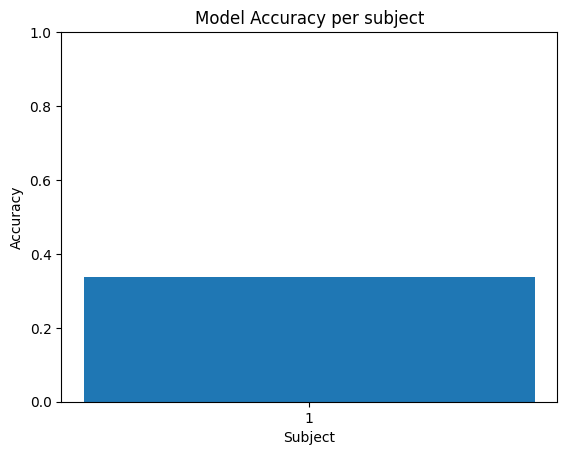

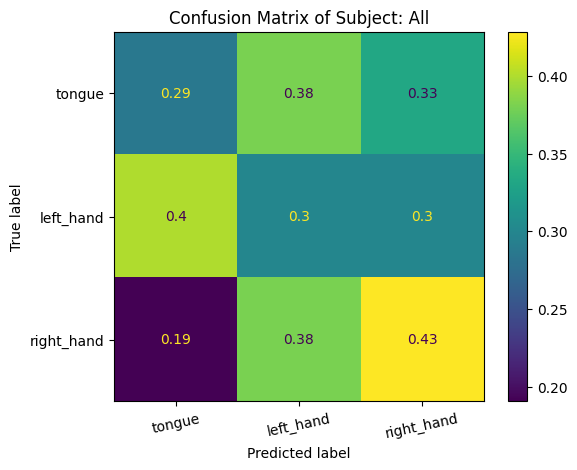

In [38]:
acc = test(y_test_onehot_arr,y_pred_arr, dataset_conf,'./results/')